Note: Much code taken from Neuromatch NeuroAI 2024 Microlearning.

In [1]:
# dependencies
from IPython.display import Image, SVG, display
import os
from pathlib import Path

import random
from tqdm import tqdm
import warnings
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import torchvision
import contextlib
import io

from helpers import sigmoid, ReLU, add_bias, create_batches, calculate_accuracy, calculate_cosine_similarity

In [2]:
# Download MNIST function
def download_mnist(train_prop=0.8, keep_prop=0.5):

  valid_prop = 1 - train_prop

  discard_prop = 1 - keep_prop

  transform = torchvision.transforms.Compose(
      [torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307,), (0.3081,))]
      )


  with contextlib.redirect_stdout(io.StringIO()): #to suppress output
    
    rng_data = np.random.default_rng(seed=42)
    train_num = 50000
    shuffled_train_idx = rng_data.permutation(train_num)

    full_train_set = torchvision.datasets.MNIST(
          root="./data/", train=True, download=True, transform=transform)
    full_test_set = torchvision.datasets.MNIST(
          root="./data/", train=False, download=True, transform=transform)
    
    full_train_images = full_train_set.data.numpy().astype(float) / 255
    train_images = full_train_images[shuffled_train_idx[:train_num]].reshape((-1, 784)).T.copy()
    valid_images = full_train_images[shuffled_train_idx[train_num:]].reshape((-1, 784)).T.copy()
    test_images = (full_test_set.data.numpy().astype(float) / 255).reshape((-1, 784)).T

    full_train_labels = torch.nn.functional.one_hot(full_train_set.targets, num_classes=10).numpy()
    train_labels = full_train_labels[shuffled_train_idx[:train_num]].T.copy()
    valid_labels = full_train_labels[shuffled_train_idx[train_num:]].T.copy()
    test_labels = torch.nn.functional.one_hot(full_test_set.targets, num_classes=10).numpy().T

    train_set, valid_set, _ = torch.utils.data.random_split(
      full_train_set, [train_prop * keep_prop, valid_prop * keep_prop, discard_prop])
    test_set, _ = torch.utils.data.random_split(
      full_test_set, [keep_prop, discard_prop])

  print("Number of examples retained:")
  print(f"  {len(train_set)} (training)")
  print(f"  {len(valid_set)} (validation)")
  print(f"  {len(test_set)} (test)")

  return train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels

In [3]:
train_set, valid_set, test_set, train_images, valid_images, test_images, train_labels, valid_labels, test_labels = download_mnist()

Number of examples retained:
  24001 (training)
  5999 (validation)
  5000 (test)


In [38]:
#HYPERPARAMETERS
NUM_INPUTS = 784
NUM_OUTPUTS = 10
numhidden = 500
batchsize = 128
initweight = 0.1
learnrate = 0.001
noise = 0.1
numepochs = 25
numrepeats = 1
numbatches = int(train_images.shape[1] / batchsize)
numupdates = numepochs * numbatches
activation = 'sigmoid'
report = True
rep_rate = 1
seed = 12345

In [5]:
def get_plotting_color(dataset="train", model_idx=None):
  if model_idx is not None:
    dataset = None

  if model_idx == 0 or dataset == "train":
    color = "#1F77B4" # blue
  elif model_idx == 1 or dataset == "valid":
    color = "#FF7F0E" # orange
  elif model_idx == 2 or dataset == "test":
    color = "#2CA02C" # green
  else:
    if model_idx is not None:
      raise NotImplementedError("Colors only implemented for up to 3 models.")
    else:
      raise NotImplementedError(
          f"{dataset} dataset not recognized. Expected 'train', 'valid' "
          "or 'test'."
          )

  return color


#@markdown `plot_examples(subset)`: Plot examples from the dataset organized by their predicted class
#@markdown (if a model is provided) or by their class label otherwise
def plot_examples(subset, num_examples_per_class=8, MLP=None, seed=None,
                  batch_size=32, num_classes=10, ax=None):
  """
  Function for visualizing example images from the dataset, organized by their
  predicted class, if a model is provided, or by their class, otherwise.

  Arguments:
  - subset (torch dataset or torch dataset subset): dataset from which to
    visualized images.
  - num_examples_per_class (int, optional): number of examples to visualize per
    class
  - MLP (MultiLayerPerceptron or None, optional): model to use to retrieve the
    predicted class for each image. If MLP is None, images will be organized by
    their class label. Otherwise, images will be organized by their predicted
    class.
  - seed (int or None, optional): Seed to use to randomly sample images to
    visualize.
  - batch_size (int, optional): If MLP is not None, number of images to
    retrieve predicted class for at one time.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if MLP is None:
    xlabel = "Class"
  else:
    MLP.eval()
    xlabel = "Predicted class"

  if ax is None:
    fig_wid = min(8, num_classes * 0.6)
    fig_hei = min(8, num_examples_per_class * 0.6)
    _, ax = plt.subplots(figsize=(fig_wid, fig_hei))

  if seed is None:
    generator = None
  else:
    generator = torch.Generator()
    generator.manual_seed(seed)

  loader = torch.utils.data.DataLoader(
      subset, batch_size=batch_size, shuffle=True, generator=generator
      )

  plot_images = {i: list() for i in range(num_classes)}
  with torch.no_grad():
    for X, y in loader:
      if MLP is not None:
        y = MLP(X)
        y = torch.argmax(y, axis=1)

      done = True
      for i in range(num_classes):
        num_to_add = int(num_examples_per_class - len(plot_images[i]))
        if num_to_add:
          add_images = np.where(y == i)[0]
          if len(add_images):
            for add_i in add_images[: num_to_add]:
              plot_images[i].append(X[add_i, 0].numpy())
          if len(plot_images[i]) != num_examples_per_class:
            done = False

      if done:
        break

  hei, wid = X[0, 0].shape
  final_image = np.full((num_examples_per_class * hei, num_classes * wid), np.nan)
  for i, images in plot_images.items():
    if len(images):
      final_image[: len(images) * hei, i * wid: (i + 1) * wid] = np.vstack(images)

  ax.imshow(final_image, cmap="gray")

  ax.set_xlabel(xlabel)
  ax.set_xticks((np.arange(num_classes) + 0.5) * wid)
  ax.set_xticklabels([f"{int(i)}" for i in range(num_classes)])
  ax.set_yticks([])
  ax.set_title(f"Examples per {xlabel.lower()}")

  return ax

#@markdown `plot_class_distribution(train_set)`: Plots the distribution of classes in each set (train, validation, test).
def plot_class_distribution(train_set, valid_set=None, test_set=None,
                            num_classes=10, ax=None):
  """
  Function for plotting the number of examples per class in each subset.

  Arguments:
  - train_set (torch dataset or torch dataset subset): training dataset
  - valid_set (torch dataset or torch dataset subset, optional): validation
    dataset
  - test_set (torch dataset or torch dataset subset, optional): test
    dataset
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot images. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which images were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  bins = np.arange(num_classes + 1) - 0.5

  for dataset_name, dataset in [
      ("train", train_set), ("valid", valid_set), ("test", test_set)
      ]:
    if dataset is None:
      continue

    if hasattr(dataset, "dataset"):
      targets = dataset.dataset.targets[dataset.indices]
    else:
      targets = dataset.targets

    outputs = ax.hist(
        targets,
        bins=bins,
        alpha=0.3,
        color=get_plotting_color(dataset_name),
        label=dataset_name,
        )

    per_class = len(targets) / num_classes
    ax.axhline(
        per_class,
        ls="dashed",
        color=get_plotting_color(dataset_name),
        alpha=0.8
        )

  ax.set_xticks(range(num_classes))
  ax.set_title("Counts per class")
  ax.set_xlabel("Class")
  ax.set_ylabel("Count")
  ax.legend(loc="center right")

  return ax

In [6]:
#@markdown `plot_results(results_dict)`: Plots classification losses and
#@markdown accuracies across epochs for the training and validation sets.
def plot_results(results_dict, num_classes=10, ax=None):
  """
  Function for plotting losses and accuracies across learning.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (float, optional): Number of classes, used to calculate chance
    accuracy.
  - ax (plt subplot, optional): Axis on which to plot results. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which results were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(7, 3.5))

  loss_ax = ax
  acc_ax = None

  chance = 100 / num_classes

  plotted = False
  for result_type in ["losses", "accuracies"]:
    for dataset in ["train", "valid"]:
      key = f"avg_{dataset}_{result_type}"
      if key in results_dict.keys():
        if result_type == "losses":
          ylabel = "Loss"
          plot_ax = loss_ax
          ls = None
        elif result_type == "accuracies":
          if acc_ax is None:
            acc_ax = ax.twinx()
            acc_ax.spines[["right"]].set_visible(True)
            acc_ax.axhline(chance, ls="dashed", color="k", alpha=0.8)
            acc_ax.set_ylim(-5, 105)
          ylabel = "Accuracy (%)"
          plot_ax = acc_ax
          ls = "dashed"
        else:
          raise RuntimeError(f"{result_type} result type not recognized.")

        data = results_dict[key]
        plot_ax.plot(
            data,
            ls=ls,
            label=dataset,
            alpha=0.8,
            color=get_plotting_color(dataset)
            )
        plot_ax.set_ylabel(ylabel)
        plotted = True

  if plotted:
    ax.legend(loc="center left")
    ax.set_xticks(range(len(data)))
    ax.set_xticklabels([f"{int(e)}" for e in range(len(data))])
    ymin, ymax = ax.get_ylim()
    if ymin > 0:
      ymin = 0
      pad = (ymax - ymin) * 0.05
      ax.set_ylim(ymin - pad, ymax + pad)

  else:
    raise RuntimeError("No data found to plot.")

  ax.set_title("Performance across learning")
  ax.set_xlabel("Epoch")

  return ax


#@markdown `plot_scores_per_class(results_dict)`: Plots the classification
#@markdown accuracies by class for the training and validation sets (for the last epoch).
def plot_scores_per_class(results_dict, num_classes=10, ax=None):
  """
  Function for plotting accuracy scores for each class.

  Arguments:
  - results_dict (dict): Dictionary storing results across epochs on training
    and validation data.
  - num_classes (int, optional): Number of classes in the data.
  - ax (plt subplot, optional): Axis on which to plot accuracies. If None, a new
    axis will be created.

  Returns:
  - ax (plt subplot): Axis on which accuracies were plotted.
  """

  if ax is None:
    _, ax = plt.subplots(figsize=(6, 3))

  avgs = list()
  ax.set_prop_cycle(None) # reset color cycle
  for s, dataset in enumerate(["train", "valid"]):
    correct_by_class = results_dict[f"{dataset}_correct_by_class"]
    seen_by_class = results_dict[f"{dataset}_seen_by_class"]
    xs, ys = list(), list()
    for i, total in seen_by_class.items():
      xs.append(i + 0.3 * (s - 0.5))
      if total == 0:
        ys.append(np.nan)
      else:
        ys.append(100 * correct_by_class[i] / total)

    avg_key = f"avg_{dataset}_accuracies"
    if avg_key in results_dict.keys():
      ax.axhline(
          results_dict[avg_key][-1], ls="dashed", alpha=0.8,
          color=get_plotting_color(dataset)
          )

    ax.bar(
        xs, ys, label=dataset, width=0.3, alpha=0.8,
        color=get_plotting_color(dataset)
        )

  ax.set_xticks(range(num_classes))
  ax.set_xlabel("Class")
  ax.set_ylabel("Accuracy (%)")
  ax.set_title("Class scores")
  ax.set_ylim(-5, 105)

  chance = 100 / num_classes
  ax.axhline(chance, ls="dashed", color="k", alpha=0.8)

  ax.legend()

  return ax


#@markdown `plot_weights(MLP)`: Plots weights before and after training.
def plot_weights(MLP, shared_colorbar=False):
  """
  Function for plotting model weights and biases before and after learning.

  Arguments:
  - MLP (torch model): Model for which to plot weights and biases.
  - shared_colorbar (bool, optional): If True, one colorbar is shared for all
      parameters.

  Returns:
  - ax (plt subplot array): Axes on which weights and biases were plotted.
  """

  param_names = MLP.list_parameters()

  params_images = dict()
  pre_means = dict()
  post_means = dict()
  vmin, vmax = np.inf, -np.inf
  for param_name in param_names:
    layer, param_type = param_name.split("_")
    init_params = getattr(MLP, f"init_{layer}_{param_type}").numpy()
    separator = np.full((1, init_params.shape[-1]), np.nan)
    last_params = getattr(getattr(MLP, layer), param_type).detach().numpy()
    diff_params = last_params - init_params

    params_image = np.vstack(
        [init_params, separator, last_params, separator, diff_params]
        )
    vmin = min(vmin, np.nanmin(params_image))
    vmax = min(vmax, np.nanmax(params_image))

    params_images[param_name] = params_image
    pre_means[param_name] = init_params.mean()
    post_means[param_name] = last_params.mean()

  nrows = len(param_names)
  gridspec_kw = dict()
  if len(param_names) == 4:
    gridspec_kw["height_ratios"] = [5, 1, 5, 1]
    cbar_label = "Weight/bias values"
  elif len(param_names) == 2:
    gridspec_kw["height_ratios"] = [5, 5]
    cbar_label = "Weight values"
  else:
    raise NotImplementedError("Expected 2 parameters (weights only) or "
      f"4 parameters (weights and biases), but found {len(param_names)}"
    )

  if shared_colorbar:
    nrows += 1
    gridspec_kw["height_ratios"].append(1)
  else:
    vmin, vmax = None, None

  fig, axes = plt.subplots(
      nrows, 1, figsize=(6, nrows + 3), gridspec_kw=gridspec_kw
      )

  for i, (param_name, params_image) in enumerate(params_images.items()):
    layer, param_type = param_name.split("_")
    layer_str = "First" if layer == "lin1" else "Second"
    param_str = "weights" if param_type == "weight" else "biases"

    axes[i].set_title(f"{layer_str} linear layer {param_str} (pre, post and diff)")
    im = axes[i].imshow(params_image, aspect="auto", vmin=vmin, vmax=vmax)
    if not shared_colorbar:
      cbar = fig.colorbar(im, ax=axes[i], aspect=10)
      cbar.ax.axhline(pre_means[param_name], ls="dotted", color="k", alpha=0.5)
      cbar.ax.axhline(post_means[param_name], color="k", alpha=0.5)

    if param_type == "weight":
      axes[i].set_xlabel("Input dim.")
      axes[i].set_ylabel("Output dim.")
    axes[i].spines[["left", "bottom"]].set_visible(False)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

  if shared_colorbar:
    cax = axes[-1]
    cbar = fig.colorbar(im, cax=cax, orientation="horizontal", location="bottom")
    cax.set_xlabel(cbar_label)

  return axes

## Node Perturbation

In [29]:
# @title Helper functions

# The sigmoid activation function
def sigmoid(X):
    """
    Returns the sigmoid function, i.e. 1/(1+exp(-X))
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    toobig = X > 500
    toosmall = X < -500
    Y[toobig] = 500
    Y[toosmall] = -500

    return 1.0 / (1.0 + np.exp(-Y))

# The ReLU activation function
def ReLU(X):
    """
    Returns the ReLU function, i.e. X if X > 0, 0 otherwise
    """

    # to avoid runtime warnings, if abs(X) is more than 500, we just cap it there
    Y = X.copy()  # this ensures we don't overwrite entries in X - Python can be a trickster!
    neg = X < 0
    Y[neg] = 0

    return Y


# A helper function to add an "always on" unit to the inputs, let's us keep the biases in the weight matrices
def add_bias(inputs):
    """
    Append an "always on" bias unit to some inputs
    """
    return np.append(inputs, np.ones((1, inputs.shape[1])), axis=0)


# Creates a random set of batches, returns an array of indices, one for each batch
def create_batches(rng, batch_size, num_samples):
    """
    For a given number of samples, returns an array of indices of random batches of the specified size.

    If the size of the data is not divisible by the batch size some samples will not be included.
    """

    # determine the total number of batches
    num_batches = int(np.floor(num_samples / batch_size))

    # get the batches (without replacement)
    return rng.choice(np.arange(num_samples), size=(num_batches, batch_size), replace=False)


# Calculate the accuracy of the network on some data
def calculate_accuracy(outputs, targets):
    """
    Calculate the accuracy in categorization of some outputs given some targets.
    """

    # binarize the outputs for an easy calculation
    categories = (outputs == np.tile(outputs.max(axis=0), (10, 1))).astype('float')

    # get the accuracy
    accuracy = np.sum(categories * targets) / targets.shape[1]

    return accuracy * 100.0


def calculate_cosine_similarity(grad_1, grad_2):
    """
    Calculate the cosine similarity between two gradients
    """
    grad_1 = grad_1.flatten()
    grad_2 = grad_2.flatten()
    return np.dot(grad_1, grad_2) / np.sqrt(np.dot(grad_1, grad_1)) / np.sqrt(np.dot(grad_2, grad_2))


def calculate_grad_snr(grad, epsilon=1e-3):
    """
    Calculate the average SNR |mean|/std across all parameters in a gradient update
    """
    return np.mean(np.abs(np.mean(grad, axis=0)) / (np.std(grad, axis=0) + epsilon))

# The main network class
# This will function as the parent class for our networks, which will implement different learning algorithms
class MLP(object):
    """
    The class for creating and training a two-layer perceptron.
    """

    # The initialization function
    def __init__(self,
                rng,
                num_hidden,
                num_inputs = NUM_INPUTS,
                num_outputs = NUM_OUTPUTS,
                sigma=1.0, activation='sigmoid'):
        """
        The initialization function for the MLP.

         - N is the number of hidden units
         - sigma is the SD for initializing the weights
         - activation is the function to use for unit activity, options are 'sigmoid' and 'ReLU'
        """

        # store the variables for easy access

        super().__init__()

        self.N = num_hidden
        self.sigma = sigma
        self.activation = activation

        # initialize the weights
        #self.W_h = rng.normal(scale=self.sigma, size=(self.num_hidden, num_inputs + 1))  # input-to-hidden weights & bias
        #self.W_y = rng.normal(scale=self.sigma, size=(num_outputs, self.num_hidden + 1))  # hidden-to-output weights & bias
        #self.B = rng.normal(scale=self.sigma, size=(self.num_hidden, num_outputs))  # feedback weights

        self.W_h = rng.normal(scale=self.sigma, size=(self.N, num_inputs+1))  # input-to-hidden weights & bias
        self.W_y = rng.normal(scale=self.sigma, size=(10, self.N + 1))  # hidden-to-output weights & bias
        self.B = rng.normal(scale=self.sigma, size=(self.N, 10))  
    def _store_initial_weights_biases(self):
        """
        Stores a copy of the network's initial weights and biases.
        """

        self.init_lin1_weight = self.lin1.weight.data.clone()
        self.init_lin2_weight = self.lin2.weight.data.clone()
        if self.bias:
            self.init_lin1_bias = self.lin1.bias.data.clone()
            self.init_lin2_bias = self.lin2.bias.data.clone()
        

    def _set_activation(self):
        """
        Sets the activation function used for the hidden layer.
        """

        if self.activation_type.lower() == "sigmoid":
            self.activation = torch.nn.Sigmoid() # maps to [0, 1]
        elif self.activation_type.lower() == "tanh":
            self.activation = torch.nn.Tanh() # maps to [-1, 1]
        elif self.activation_type.lower() == "relu":
            self.activation = torch.nn.ReLU() # maps to positive
        elif self.activation_type.lower() == "identity":
            self.activation = torch.nn.Identity() # maps to same
        else:
            raise NotImplementedError(
                f"{self.activation_type} activation type not recognized. Only "
                "'sigmoid', 'relu' and 'identity' have been implemented so far.")

    # The non-linear activation function
    def activate(self, inputs):
        """
        Pass some inputs through the activation function.
        """
        if self.activation == 'sigmoid':
            Y = sigmoid(inputs)
        elif self.activation == 'ReLU':
            Y = ReLU(inputs)
        else:
            raise Exception("Unknown activation function")
        return Y

    # The function for performing a forward pass up through the network during inference
    def inference(self, rng, inputs, W_h=None, W_y=None, noise=0.):
        """
        Recognize inputs, i.e. do a forward pass up through the network. If desired, alternative weights
        can be provided
        """

        # load the current network weights if no weights given
        if W_h is None:
            W_h = self.W_h
        if W_y is None:
            W_y = self.W_y

        # calculate the hidden activities
        hidden = self.activate(np.dot(W_h, add_bias(inputs)))
        if not (noise == 0.):
            hidden += rng.normal(scale=noise, size=hidden.shape)

        # calculate the output activities
        output = self.activate(np.dot(W_y, add_bias(hidden)))

        if not (noise == 0.):
            output += rng.normal(scale=noise, size=output.shape)

        return hidden, output

    def forward(self, X, y=None):
        """
        Runs a forward pass through the network.

        Arguments:
        - X (torch.Tensor): Batch of input images.
        - y (torch.Tensor, optional): Batch of targets. This variable is not used
        here. However, it may be needed for other learning rules, to it is
        included as an argument here for compatibility.

        Returns:
        - y_pred (torch.Tensor): Predicted targets.
        """

        h = self.activation(self.lin1(X.reshape(-1, self.num_inputs)))
        y_pred = self.softmax(self.lin2(h))
        return y_pred

    # A function for calculating the derivative of the activation function
    def act_deriv(self, activity):
        """
        Calculate the derivative of some activations with respect to the inputs
        """
        if self.activation == 'sigmoid':
            derivative = activity * (1 - activity)
        elif self.activation == 'ReLU':
            derivative = 1.0 * (activity > 1)
        else:
            raise Exception("Unknown activation function")
        return derivative

    def mse_loss_batch(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """

        # do a forward sweep through the network
        if (output is None):
            (hidden, output) = self.inference(rng, inputs, W_h, W_y)
        return np.sum((targets - output) ** 2, axis=0)

    # The function for calculating the mean-squared error loss
    def mse_loss(self, rng, inputs, targets, W_h=None, W_y=None, output=None):
        """
        Calculate the mean-squared error loss on the given targets (average over the batch)
        """
        return np.mean(self.mse_loss_batch(rng, inputs, targets, W_h=W_h, W_y=W_y, output=output))

    # function for calculating perturbation updates
    def perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """
        raise NotImplementedError()

    # function for calculating gradient updates
    def gradient(self, rng, inputs, targets):
        """
        Calculates the weight updates for gradient descent learning
        """

        # do a forward pass
        hidden, output = self.inference(rng, inputs)

        # calculate the gradients
        error = targets - output
        delta_W_h = np.dot(
            np.dot(self.W_y[:, :-1].transpose(), error * self.act_deriv(output)) * self.act_deriv(hidden), \
            add_bias(inputs).transpose())
        delta_W_y = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())

        return delta_W_h, delta_W_y

    # function for calculating feedback alignment updates
    def feedback(self, rng, inputs, targets):
        """
        Calculates the weight updates for feedback alignment learning
        """
        raise NotImplementedError()

    # function for calculating Kolen-Pollack updates
    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        raise NotImplementedError()

    def return_grad(self, rng, inputs, targets, algorithm='backprop', eta=0., noise=1.0):
        # calculate the updates for the weights with the appropriate algorithm
        if algorithm == 'perturb':
            delta_W_h, delta_W_y = self.perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'node_perturb':
            delta_W_h, delta_W_y = self.node_perturb(rng, inputs, targets, noise=noise)
        elif algorithm == 'feedback':
            delta_W_h, delta_W_y = self.feedback(rng, inputs, targets)
        elif algorithm == 'kolepoll':
            delta_W_h, delta_W_y = self.kolepoll(rng, inputs, targets, eta_back=eta)
        else:
            delta_W_h, delta_W_y = self.gradient(rng, inputs, targets)

        return delta_W_h, delta_W_y

    # function for updating the network
    def update(self, rng, inputs, targets, algorithm='backprop', eta=0.01, noise=1.0):
        """
        Updates the synaptic weights (and unit biases) using the given algorithm, options are:

        - 'backprop': backpropagation-of-error (default)
        - 'perturb' : weight perturbation (use noise with SD as given)
        - 'feedback': feedback alignment
        - 'kolepoll': Kolen-Pollack
        """

        delta_W_h, delta_W_y = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=eta, noise=noise)

        # do the updates
        self.W_h += eta * delta_W_h
        self.W_y += eta * delta_W_y

    # train the network using the update functions
    def train(self, rng, images, labels, num_epochs, test_images, test_labels, learning_rate=0.01, batch_size=20, \
              algorithm='backprop', noise=1.0, report=False, report_rate=10):
        """
        Trains the network with algorithm in batches for the given number of epochs on the data provided.

        Uses batches with size as indicated by batch_size and given learning rate.

        For perturbation methods, uses SD of noise as given.

        Categorization accuracy on a test set is also calculated.

        Prints a message every report_rate epochs if requested.

        Returns an array of the losses achieved at each epoch (and accuracies if test data given).
        """

        # provide an output message
        if report:
            print("Training starting...")

        # make batches from the data
        batches = create_batches(rng, batch_size, images.shape[1])

        # create arrays to store loss and accuracy values
        losses = np.zeros((num_epochs * batches.shape[0],))
        accuracy = np.zeros((num_epochs,))
        test_loss = np.zeros((num_epochs,))
        cosine_similarity = np.zeros((num_epochs,))

        # estimate the gradient SNR on the test set
        grad = np.zeros((test_images.shape[1], *self.W_h.shape))
        for t in range(test_images.shape[1]):
            inputs = test_images[:, [t]]
            targets = test_labels[:, [t]]
            grad[t, ...], _ = self.return_grad(rng, inputs, targets, algorithm=algorithm, eta=0., noise=noise)
        snr = calculate_grad_snr(grad)
        # run the training for the given number of epochs
        update_counter = 0
        for epoch in range(num_epochs):

            # step through each batch
            for b in range(batches.shape[0]):
                # get the inputs and targets for this batch
                inputs = images[:, batches[b, :]]
                targets = labels[:, batches[b, :]]

                # calculate the current loss
                losses[update_counter] = self.mse_loss(rng, inputs, targets)

                # update the weights
                self.update(rng, inputs, targets, eta=learning_rate, algorithm=algorithm, noise=noise)
                update_counter += 1

            # calculate the current test accuracy
            (testhid, testout) = self.inference(rng, test_images)
            accuracy[epoch] = calculate_accuracy(testout, test_labels)
            test_loss[epoch] = self.mse_loss(rng, test_images, test_labels)
            grad_test, _ = self.return_grad(rng, test_images, test_labels, algorithm=algorithm, eta=0., noise=noise)
            grad_bp, _ = self.return_grad(rng, test_images, test_labels, algorithm='backprop', eta=0., noise=noise)
            cosine_similarity[epoch] = calculate_cosine_similarity(grad_test, grad_bp)

            # print an output message every 10 epochs
            if report and np.mod(epoch + 1, report_rate) == 0:
                print("...completed ", epoch + 1,
                      " epochs of training. Current loss: ", round(losses[update_counter - 1], 2), ".")

        # provide an output message
        if report:
            print("Training complete.")

        return (losses, accuracy, test_loss, snr)

In [30]:
class NodePerturbMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through node perturbation
    """

    def node_perturb(self, rng, inputs, targets, noise=1.0):
        """
        Calculates the weight updates for node perturbation learning, using noise with SD as given
        """

        # get the random perturbations
        hidden, output = self.inference(rng, inputs)
        hidden_p, output_p = self.inference(rng, inputs, noise=noise)

        loss_now = self.mse_loss_batch(rng, inputs, targets, output=output)
        loss_per = self.mse_loss_batch(rng, inputs, targets, output=output_p)
        delta_loss = loss_now - loss_per

        hidden_update = np.mean(
            delta_loss * (((hidden_p - hidden) / noise ** 2)[:, None, :] * add_bias(inputs)[None, :, :]), axis=2)
        output_update = np.mean(
            delta_loss * (((output_p - output) / noise ** 2)[:, None, :] * add_bias(hidden_p)[None, :, :]), axis=2)

        return (hidden_update, output_update)

In [9]:
# @title Train and observe the performance of NodePerturbMLP

losses_node_perturb = np.zeros((numupdates,))
accuracy_node_perturb = np.zeros((numepochs,))

# set the random seed
rng_np = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_np.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using weight perturbation
with contextlib.redirect_stdout(io.StringIO()):
    netnodeperturb = NodePerturbMLP(rng_np, numhidden, num_inputs = 784, sigma=initweight, activation=activation)
    (losses_node_perturb[:], accuracy_node_perturb[:], _, snr_node_perturb) = \
        netnodeperturb.train(rng_np, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                             learning_rate=learnrate, batch_size=batchsize, algorithm='node_perturb', noise=noise, \
                             report=report, report_rate=rep_rate)


In [31]:
class KolenPollackMLP(MLP):
    """
    A multilayer perceptron that is capable of learning through the Kolen-Pollack algorithm
    """

    def kolepoll(self, rng, inputs, targets, eta_back=0.01):
        """
        Calculates the weight updates for Kolen-Polack learning
        """
        ###################################################################
        ## Fill out the following then remove
        #raise NotImplementedError("Student exercise: calculate updates.")
        ###################################################################

        # do a forward pass
        (hidden, output) = self.inference(rng, inputs)

        # calculate the updates for the forward weights
        error = targets - output
        delta_W_h = np.dot(np.dot(self.B, error * self.act_deriv(output)) * self.act_deriv(hidden), \
                           add_bias(inputs).transpose())
        #delta_err = np.dot(self.W_y.T, error)
        delta_err = np.dot(error * self.act_deriv(output), add_bias(hidden).transpose())
        delta_W_y = delta_err - 0.1 * self.W_y

        # calculate the updates for the backwards weights and implement them
        delta_B = delta_err[:, :-1].transpose() - 0.1 * self.B
        self.B += eta_back * delta_B
        return (delta_W_h, delta_W_y)

In [35]:
rng_kp = np.random.default_rng(seed=seed)

losses_kolepoll = np.zeros((numupdates,))
accuracy_kolepoll = np.zeros((numepochs,))
test_loss_kolepoll = np.zeros((numepochs,))
# select 1000 random images to test the accuracy on
indices = rng_kp.choice(range(test_images.shape[1]), size=(1000,), replace=False)

# create a network and train it using feedback alignment
netkolepoll = KolenPollackMLP(rng_kp, numhidden, sigma=initweight, activation=activation)
(losses_kolepoll[:], accuracy_kolepoll[:], test_loss_kolepoll[:], _) = \
    netkolepoll.train(rng_kp, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='kolepoll', noise=noise, \
                      report=report, report_rate=rep_rate)

rng_bp2 = np.random.default_rng(seed=seed)

# select 1000 random images to test the accuracy on
indices = rng_bp2.choice(range(test_images.shape[1]), size=(1000,), replace=False)

losses_backprop = np.zeros((numupdates,))
accuracy_backprop = np.zeros((numepochs,))
test_loss_backprop = np.zeros((numepochs,))

# create a network and train it using backprop
netbackprop = MLP(rng_bp2, numhidden, sigma=initweight, activation=activation)
(losses_backprop[:], accuracy_backprop[:], test_loss_backprop[:], _) = \
    netbackprop.train(rng_bp2, train_images, train_labels, numepochs, test_images[:, indices], test_labels[:, indices], \
                      learning_rate=learnrate, batch_size=batchsize, algorithm='backprop', noise=noise, \
                      report=report, report_rate=rep_rate)

# plot performance over time


Training starting...
...completed  1  epochs of training. Current loss:  0.54 .
...completed  2  epochs of training. Current loss:  0.36 .
...completed  3  epochs of training. Current loss:  0.29 .
...completed  4  epochs of training. Current loss:  0.25 .
...completed  5  epochs of training. Current loss:  0.23 .
...completed  6  epochs of training. Current loss:  0.22 .
...completed  7  epochs of training. Current loss:  0.21 .
...completed  8  epochs of training. Current loss:  0.2 .
...completed  9  epochs of training. Current loss:  0.19 .
...completed  10  epochs of training. Current loss:  0.19 .
...completed  11  epochs of training. Current loss:  0.19 .
...completed  12  epochs of training. Current loss:  0.18 .
...completed  13  epochs of training. Current loss:  0.18 .
...completed  14  epochs of training. Current loss:  0.18 .
...completed  15  epochs of training. Current loss:  0.18 .
...completed  16  epochs of training. Current loss:  0.17 .
...completed  17  epochs of t

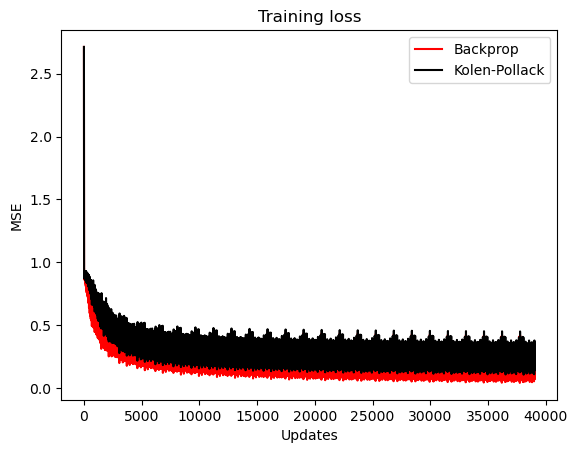

In [37]:

#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(losses_backprop, label="Backprop", color='r')
plt.plot(losses_kolepoll, label="Kolen-Pollack", color='k')
#plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Training loss")
plt.show()

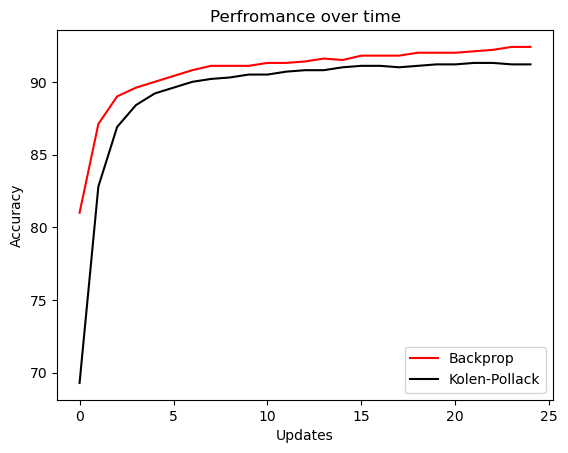

In [39]:

#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(accuracy_backprop, label="Backprop", color='r')
plt.plot(accuracy_kolepoll, label="Kolen-Pollack", color='k')
#plt.plot(accuracy_node_perturb, label="Node Perturbation", color='c')
plt.xlabel("Updates")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Perfromance over time")
plt.show()

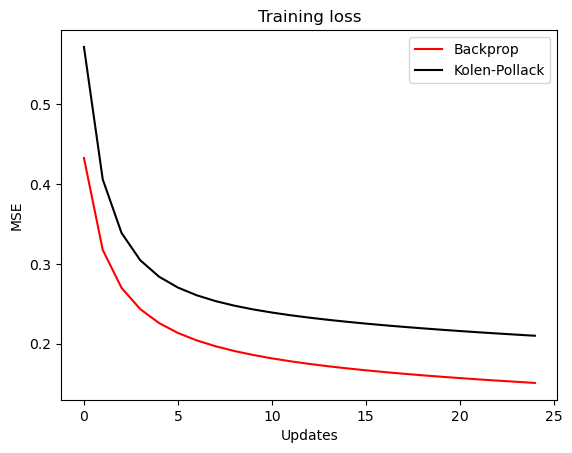

In [36]:

#plt.plot(losses_feedback, label="Feedback Alignment", color='g')
plt.plot(test_loss_backprop, label="Backprop", color='r')
plt.plot(test_loss_kolepoll, label="Kolen-Pollack", color='k')
#plt.plot(losses_node_perturb, label="Node Perturbation", color='c')
plt.xlabel("Updates")
plt.ylabel("MSE")
plt.legend()
plt.title("Test loss")
plt.show()